# References

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../fastai/') #fastai version 1
from fastai import *
from fastai.vision import *

from torch.utils.data import DataLoader, SubsetRandomSampler
import torchvision
import torch.nn.functional as F


import pdb
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path
from glob import glob
import png
from tqdm import tqdm_notebook as tqdm
import cv2
from sklearn.model_selection import train_test_split

# Global Variables

In [1]:
DP = Path('/home/Deep_Learner/work/datasets/human-protein-atlas-image-classification/')
STAGE_ONE_DATA = DP/'stage1_data'
TRAIN_PNGS = 'train_pngs_512'
TEST_PNGS = 'test_pngs_512'
TRAIN_CSV = 'train.csv'
SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'


SUBMISSIONS = DP/STAGE_ONE_DATA/'submissions'
SUBMISSIONS.mkdir(exist_ok=True)


filter_colors = ['blue', 'green', 'red', 'yellow']

IdToCatDict = {0:'Nucleoplasm',
               1:'Nuclear_membrane',
               2:'Nucleoli',
               3:'Nucleoli_fibrillar_center',
               4:'Nuclear_speckles',
               5:'Nuclear_bodies',
               6:'Endoplasmic_reticulum',
               7:'Golgi_apparatus',
               8:'Peroxisomes',
               9:'Endosomes',
               10:'Lysosomes',
               11:'Intermediate_filaments',
               12:'Actin_filaments',
               13:'Focal_adhesion_sites',
               14:'Microtubules',
               15:'Microtubule_ends',
               16:'Cytokinetic_bridge',
               17:'Mitotic_spindle',
               18:'Microtubule_organizing_center',
               19:'Centrosome',
               20:'Lipid_droplets',
               21:'Plasma_membrane',
               22:'Cell_junctions',
               23:'Mitochondria',
               24:'Aggresome',
               25:'Cytosol',
               26:'Cytoplasmic_bodies',
               27:'Rods_&_rings'}

sz = 512
bs = 8
val_split = 0.1
train_names = list(pd.read_csv(STAGE_ONE_DATA/TRAIN_CSV)['Id'])

NameError: name 'Path' is not defined

# Functions

In [30]:
def open_rgby(path,id): #a function that reads RGBY image
    colors = ['red','green','blue','yellow']
    flags = cv2.IMREAD_GRAYSCALE
    img = [cv2.imread(os.path.join(path, id+'_'+color+'.png'), flags).astype(np.float32)/255
           for color in colors]
    return np.stack(img, axis=-1)

def A(*a):
    """convert iterable object into numpy array"""
    return np.array(a[0]) if len(a)==1 else [np.array(o) for o in a]

# Data

In [31]:
class CustomDataset(DatasetBase):
    def __init__(self, 
                 path:pathlib.Path, 
                 csv_path:pathlib.Path, 
                 coloumn_idx_fns:int, 
                 coloumn_idx_targets:int, 
                 transforms:list, 
                 isTest:bool, 
                 img_size:int, 
                 classes:list, 
                 class2idx:Dict[Any,int]=None):
        """
        write description here

        # Arguments
          path: pathlib.Path to images folder
          csv_path: pathlib.Path to csv file with coloums of image ids (without the colour suffix) 
                      and the targets as integers separated with spaces
          transforms: list of transform functions (e.g. from fastai.vision.transform)
          isTest: specify if it is a test set and therefore does not have labels
          coloumn_idx_fns: coloumn index in the csv file, where the filenames/fileindices are
          coloumn_idx_targets: coloumn index in the csv file, where the targets are
          img_size: size the images get resized to          
        # Returns
        
        # Raises
        """
        super().__init__()
        self.path = path
        self.df = pd.read_csv(csv_path)
        self.coloumn_idx_fns = coloumn_idx_fns
        self.coloumn_idx_targets = coloumn_idx_targets
        self.transforms = transforms
        self.isTest = isTest
        self.sz = img_size
        self.classes = classes
        self.c = len(classes)
        if class2idx is None: self.class2idx = {v:k for k,v in enumerate(self.classes)}

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):    
        return self.__get_x(idx), self.__get_y(idx)

    
    def __get_x(self, idx):
        img = open_rgby(self.path,self.df.iloc[idx, self.coloumn_idx_fns])
        img = cv2.resize(img, (self.sz, self.sz),cv2.INTER_AREA)
        if self.transforms is not None:
            img = self.transforms(data)
        img = pil2tensor(img,np.float32).float()
        img = Image(img)
        return img
    
    def __get_y(self, idx):
        if self.isTest:
            return [-1]
        labels = self.df.iloc[idx, self.coloumn_idx_targets].split()
        labels = [int(s) for s in labels]
        labels = np.asarray(labels)
        labels = self.__one_hot_encode(labels)
        return labels
    
    def __one_hot_encode(self, labels:np.array):
        a = np.zeros(len(self.classes), dtype=np.int)
        for i in labels:
            a[i] = 1
        return a

In [32]:
tfms = [RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True)]

In [33]:
dataset = CustomDataset(path=STAGE_ONE_DATA/TRAIN_PNGS, 
                        csv_path=STAGE_ONE_DATA/TRAIN_CSV, 
                        coloumn_idx_fns=0, 
                        coloumn_idx_targets=1, 
                        transforms=tfms, 
                        isTest=False, 
                        img_size=sz, 
                        classes=list(IdToCatDict.values()))

dataset_test = CustomDataset(path=STAGE_ONE_DATA/TEST_PNGS, 
                        csv_path=STAGE_ONE_DATA/SAMPLE_SUBMISSION_CSV, 
                        coloumn_idx_fns=0, 
                        coloumn_idx_targets=1, 
                        transforms=None, 
                        isTest=True, 
                        img_size=sz,
                        classes=list(IdToCatDict.values()))

tr_idxs, val_idxs = train_test_split(np.arange(len(train_names)), test_size=val_split, random_state=42)
train_sampler = SubsetRandomSampler(tr_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

train_loader = DataLoader(dataset=dataset, batch_size=bs, sampler=train_sampler, num_workers=6)
val_loader = DataLoader(dataset=dataset, batch_size=bs, sampler=val_sampler, num_workers=6)
test_loader = DataLoader(dataset=dataset_test, batch_size=bs, num_workers=4)


stats = A([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])
data = ImageDataBunch(train_dl=train_loader, 
                       valid_dl=val_loader, 
                       test_dl=test_loader, 
                       device=None, 
                       tfms=None, 
                       path=STAGE_ONE_DATA).normalize(stats)

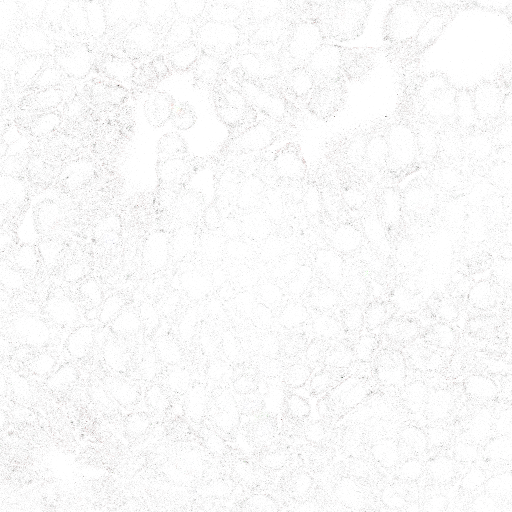

In [39]:
train_loader.dataset[0][0]

# Loss Function

In [20]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()
    
def acc(preds,targs,th=0.0):
    preds = (preds > th).int()
    targs = targs.int()
    return (preds==targs).float().mean()

f1_score = partial(fbeta, thresh=0.5, beta=1)

# Model

# Training

In [40]:
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Resnet4Channel(152).to(device)

In [41]:
learn = ClassificationLearner(
    data=data,
    model=model,
    loss_func=F.binary_cross_entropy_with_logits,
    #loss_func=FocalLoss(),
    path=STAGE_ONE_DATA,    
    metrics=[f1_score]
)

In [42]:
learn.unfreeze()

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: TensorIterator expected type torch.cuda.DoubleTensor but got torch.cuda.FloatTensor

# Obsolete

## Data Setup

In [ ]:
if os.path.isfile(STAGE_ONE_DATA/TRAIN_LABELS):
    trainFns_df = pd.read_csv(STAGE_ONE_DATA/TRAIN_LABELS)

else:
    trainIds_df = pd.read_csv(DP/'train.csv')
    trainFns_df = pd.DataFrame(columns=['name','label'])
    
    for index, row in tqdm(trainIds_df.iterrows(), total=trainIds_df.shape[0]):
        bn = row['Id']
        cats = row['Target']
        for c in filter_colors:
            fn = f'{bn}_{c}'
            trainFns_df = trainFns_df.append({'name': fn, 'label': cats}, ignore_index=True)
            
    trainFns_df.to_csv(STAGE_ONE_DATA/TRAIN_LABELS, index=False)


trainFns_df.head()

In [ ]:
tfms = get_transforms(flip_vert=True)
stage1_data = ImageDataBunch.from_csv(path=STAGE_ONE_DATA, 
                                      folder=TRAIN_PNGS, 
                                      suffix='.png', 
                                      test=TEST_PNGS, 
                                      ds_tfms=tfms, 
                                      size=sz,
                                      valid_pct=0.1)

In [ ]:
stage1_data.show_batch(rows=5, figsize=(25,25))

## Train

In [ ]:
learner = create_cnn(stage1_data, models.resnet152, metrics=[accuracy])

In [ ]:
lr = 1e-2*1.8
lrs = np.array([lr/100,lr/10,lr])

In [ ]:
learner.lr_find(start_lr=lrs/1000, end_lr=1)

In [ ]:
learner.recorder.plot()

In [ ]:
callbacks = [ReduceLROnPlateauCallback(learn=learner, patience=8)]
learner.fit(epochs=100, lr=lrs, callbacks=callbacks)